<a href="https://colab.research.google.com/github/jcausey-astate/ASRI-2025/blob/main/python_intermediate_clustering_complete_ASRI25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering in Python (Intermediate)

## ASRI 2025

![Classification in Python (Intermediate)](https://jcausey-astate.github.io/ASRI-2025/images/clustering_in_python_title_card.svg)

This notebook shows some introductory examples from the "Clustering in Python"
workshop session.

The notebook uses the following modules:

* `matplotlib`  : Provides basic graphing/charting.
* `numpy`       : Allows matrix and vector/array math.
* `pandas`      : Provides DataFrame functionality.
* `scipy`       : SciPy provides algorithms for optimization, algebraic equations, statistics and many other classes of problems.  We will use it for building dendrograms.
* `seaborn`     : Works with `matplotlib` to provide nicer graphs.
* `sklearn`     : Scikit-Learn provides machine learning and data manipulation
  tools.

We will rely heavily on the Scikit-Learn library for models, metrics, and
experimental design tools.  See the full documentation for this fantastic
library at <https://scikit-learn.org>.

---

**Clustering** is an _unsupervised_ learning technique for exploring
relationships between the random variables in a dataset.  We use a clustering
analysis to try to identify groups or similar objects in datasets with two or
more random variables.

In this tutorial, we will look at some commonly-used clustering techniques:

* **k-Means Clustering**
  * Probably the most common clustering technique.
  * Good for finding clusters that look like "blobs" when visualized.
  * You need to know the number of clusters in advance.
* **Mean Shift Clustering**
  * Doesn't require assumptions about the number of clusters.
  * Somewhat robust when clusters are not simple "blobs".
* **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise)
  * Clusters areas of similar _density_, regardless of cluster "shape".
  * Works for situations where clusters don't look like separate "blobs".
  * You don't need to know the number of clusters in advance.
* **Agglomerative Hierarchical Clustering**
  * Establishes relationships at all levels of the comparison metric between all
    samples.
  * Can be visualized as a _dendrogram_.
  * Allows you to determine the "right" number of clusters by examining the
    dendrogram.
* **Gaussian Mixture Model**
  * Assumes the data can be represented as some number of multi-dimensional
    Gaussian distributions.
  * Works well when the data are "blob" shaped, even when they overlap --
    especially if the density of the blobs differ.
  * Ideally, you need to know how many "blobs" to expect.

ℹ️  More information about these techniques and many others is available at
<https://scikit-learn.org/stable/modules/clustering.html>.

---

## Let's see some code

First, we have to import the modules, objects, and functions we will be using in
this tutorial:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import cluster
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

## Comparing clustering techniques

💡  _There is no single perfect clustering algorithm._ Different algorithms make
different assumptions with regards to what you already know about your dataset.

For that reason, we will use a few different datasets to illustrate the
strengths and weaknesses of each clustering algorithm.

**Here are the datasets we will use:**

* **Palmer Penguins** : This real-world dataset contains measurements of the
  bill length versus the flipper length of three species of penguins at the Palmer
  Antarctic research station.
  <https://allisonhorst.github.io/palmerpenguins/articles/intro.html>
* **Moons** : This simulated dataset consists of two crescent "moon" shapes,
  with one inverted so that there is no way to linearly separate the two groups,
  but they are visually separate.
* **Circles** : This simulated dataset consists of two concentric rings,
  representing noisy values that are in one of two groups, assigned by the
  radius of the ring in which the sample is located.
* **Density Blobs** : This simulated dataset will consist of three "blobs" with
  widely varying density and size characteristics.  The blobs overlap so that
  they are not perfectly visually separable.

The following code block creates the simulated datasets and loads the Palmer
Penguins dataset and selects the two predictors we will use for this tutorial.

In [3]:
n_samples = 500

# penguins : this is a real dataset, so we will load it and select a useful set of
#            features.  We will also store the labels.
penguins = sns.load_dataset("penguins").dropna(
    axis=0, subset=["bill_length_mm", "flipper_length_mm"]
)
penguins_encoder = LabelEncoder().fit(penguins["species"].values)
penguins_classes = penguins_encoder.classes_
penguins_labels = penguins_encoder.transform(penguins["species"].values)
penguins = penguins[["bill_length_mm", "flipper_length_mm"]].values
penguins = StandardScaler().fit_transform(penguins)

# moons : two crescent "moon" shapes, with one inverted so that there is no way to
# linearly separate the two groups, but they are visually separate.
moons, moons_labels = datasets.make_moons(n_samples=n_samples, noise=0.065)
moons = StandardScaler().fit_transform(moons)

# circles : two concentric rings, representing noisy values that are in one of two
# groups, assigned by the radius of the ring in which the sample is located.
circles, circles_labels = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.065
)
circles = StandardScaler().fit_transform(circles)

# density blobs : three "blobs" with widely varying density and size characteristics.
# The blobs overlap so that they are not perfectly visually separable.
density_blobs, density_blobs_labels = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.9, 0.5, 2.7], random_state=4
)
density_blobs = StandardScaler().fit_transform(density_blobs)

💡  To make understanding the data easier, we need a way to visualize the
datasets, plus give hints about what the "expected" labeling would be as well as
what a clustering technique assigns as labels.

We will create a function that can take a list of datasets with corresponding
names, labels, and styles.  The function will use the Seaborn `scatterplot()`
function to plot the datasets in a grid.

In [4]:
def plot_all(data_list, names=None, label_list=None, style_list=None):
    """
    Plot scatterplots for all the 2-D datasets in `data_list`.
    `names` provide a title for each plot
    `label_list` is a list of label assignments for the samples in the data list.
    `style_list` is a list of marker shape assignments for the samples in the data list.
    """
    nrows = int(round(len(data_list) / 2, 0))
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 10))
    for r in range(nrows):
        for c in range(2):
            hue = label_list[r * 2 + c] if label_list is not None else None
            style = style_list[r * 2 + c] if style_list is not None else None
            title = names[r * 2 + c] if names is not None else None
            sns.scatterplot(
                x=data_list[r * 2 + c][:, 0],
                y=data_list[r * 2 + c][:, 1],
                hue=hue,
                style=style,
                palette=sns.color_palette(n_colors=len(set(hue))),
                legend=False,
                ax=axs[r, c],
            ).set(title=title)
    plt.subplots_adjust(wspace=0.50)
    plt.show()

Now, let's use the `plot_all()` function to plot our four datasets.  We will use
the "real" labels to color the points so that you can see what the "ideal"
labeling would be.

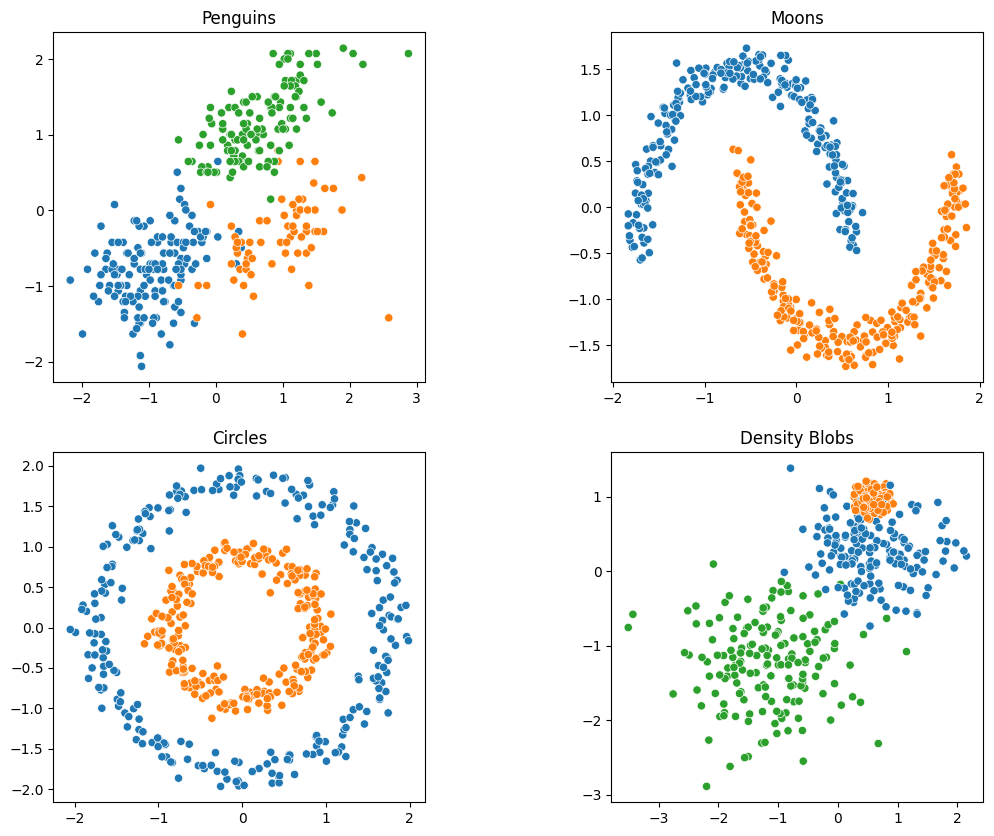

In [5]:
plot_all(
    [penguins, moons, circles, density_blobs],
    ["Penguins", "Moons", "Circles", "Density Blobs"],
    [penguins_labels, moons_labels, circles_labels, density_blobs_labels],
)

💡  **Keep in mind** that in many real-world clustering applications, we will
_not_ know what the "correct" or "ideal" labels are.

💡  **That is the "main idea" of clustering:**  It is a technique for
_suggesting a possible labeling_ for a dataset by examining relationships
between the samples.

### k-Means

Let's start with **_k-Means_** clustering. **k-Means is probably the most well-known
clustering technique because it is simple**, intuitive to understand, and it works
well for clustering lots of datasets where we can visually identify "groups" in
a scatterplot.

k-Means works by first choosing a value $k$ that represents _the desired number
of clusters_.  You need to already know something about the dataset to correctly
choose $k$ (for example, you may visualize it first and choose the number that
seem right from looking at the scatterplot).  There are also some techniques for
choosing $k$ if you have no idea of what to try.  (See:
<https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb>)

Let's see how k-Means would label each of our test datasets.  We "know" from
looking at the scatterplots that there are three groups in the "penguins" and
"density blobs" datasets, and there are two groups in the "moons" and "circles"
datasets.  So, we will choose $k$ for each dataset to match our expectation.

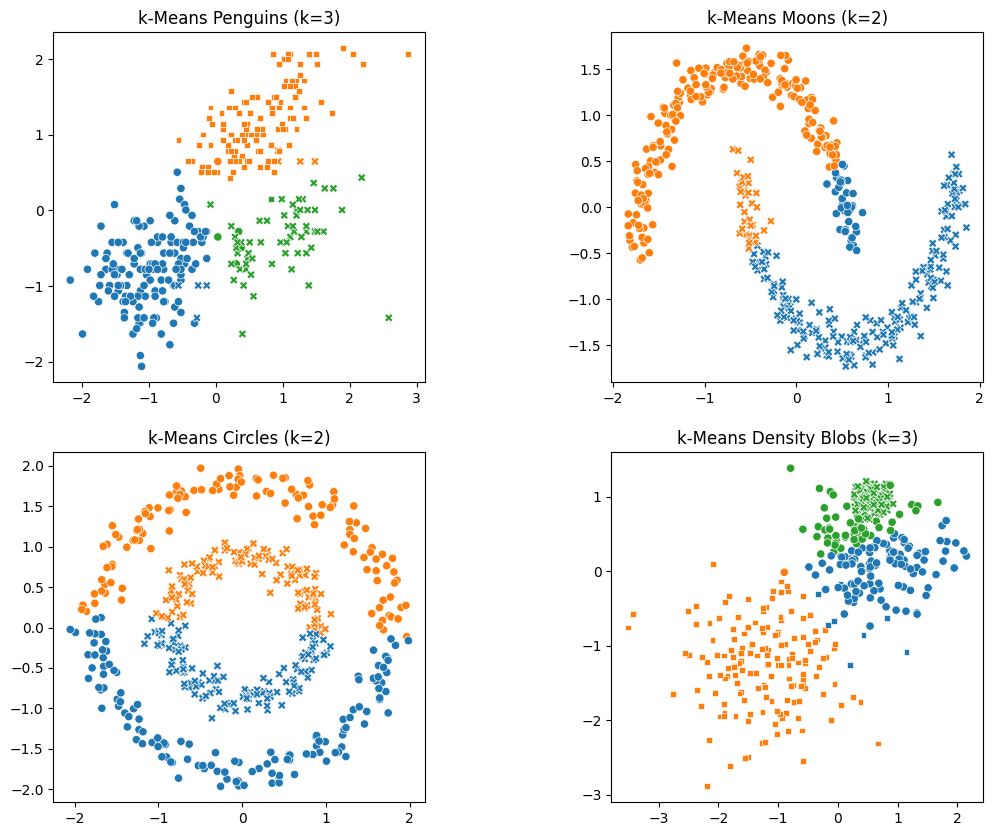

In [6]:
kmeans_2 = KMeans(n_clusters=2, random_state=1)  # k-Means with 2 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=1)  # k-Means with 3 clusters

# We apply k-Means to each dataset with the `fit_transform()` method.  We "believe"
# that "moons" and "circles" should have k=2 and "penguins" and "density_blobs"
# should have k=3.
#
penguins_kmeans = kmeans_3.fit_predict(penguins)
moons_kmeans = kmeans_2.fit_predict(moons)
circles_kmeans = kmeans_2.fit_predict(circles)
density_blobs_kmeans = kmeans_3.fit_predict(density_blobs)

# Now let's see how the proposed clusters look.  We will use the "ideal" labels
# to determine the shapes of the markers in the plots here so that we can compare:
#
plot_all(
    [penguins, moons, circles, density_blobs],
    [
        "k-Means Penguins (k=3)",
        "k-Means Moons (k=2)",
        "k-Means Circles (k=2)",
        "k-Means Density Blobs (k=3)",
    ],
    [penguins_kmeans, moons_kmeans, circles_kmeans, density_blobs_kmeans],
    [penguins_labels, moons_labels, circles_labels, density_blobs_labels],
)

🤔  We can see that k-Means does a reasonable job of finding the three groups in the
"penguins" dataset.  One of those groups (the Chinstrap penguins) is difficult
to separate even with more complicated methods.  The method does a good job of
separating the two "easier" groups (Adelie and Gentoo).

❓  **_What if we chose $k$ incorrectly?_**   Let's see by first assuming $k=2$
for all four datasets:

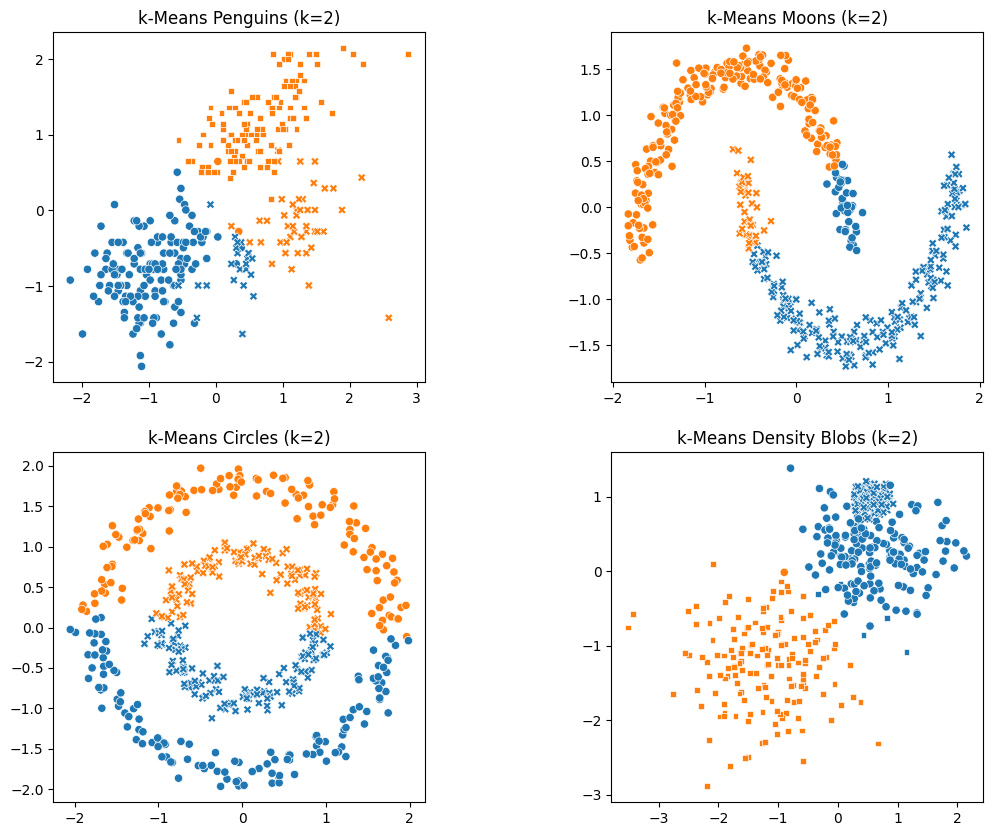

In [7]:
# What if we believe there are 2 clusters in each of the datasets?
#
kmeans_2 = KMeans(n_clusters=2, random_state=1)  # k-Means with 2 clusters

# We apply k-Means to each dataset with the `fit_transform()` method.
#
penguins_kmeans = kmeans_2.fit_predict(penguins)
moons_kmeans = kmeans_2.fit_predict(moons)
circles_kmeans = kmeans_2.fit_predict(circles)
density_blobs_kmeans = kmeans_2.fit_predict(density_blobs)

# Now let's see how the proposed clusters look.  We will use the "ideal" labels
# to determine the shapes of the markers in the plots here so that we can compare:
#
plot_all(
    [penguins, moons, circles, density_blobs],
    [
        "k-Means Penguins (k=2)",
        "k-Means Moons (k=2)",
        "k-Means Circles (k=2)",
        "k-Means Density Blobs (k=2)",
    ],
    [penguins_kmeans, moons_kmeans, circles_kmeans, density_blobs_kmeans],
    [penguins_labels, moons_labels, circles_labels, density_blobs_labels],
)

❓  What do you think about these clusters?

Now, let's incorrectly assume $k=4$ for all four datasets:

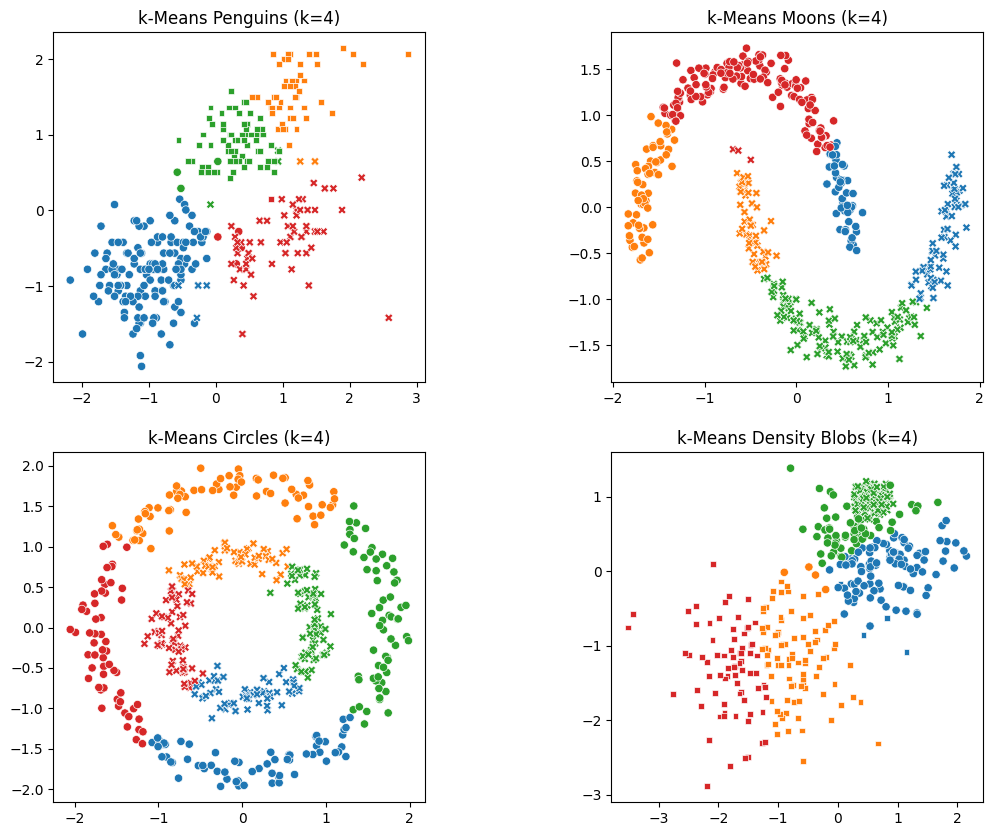

In [8]:
# What if we believe there are 4 clusters in all of the datasets?
#
kmeans_4 = KMeans(n_clusters=4, random_state=1)  # k-Means with 4 clusters

# We apply k-Means to each dataset with the `fit_transform()` method.
#
penguins_kmeans = kmeans_4.fit_predict(penguins)
moons_kmeans = kmeans_4.fit_predict(moons)
circles_kmeans = kmeans_4.fit_predict(circles)
density_blobs_kmeans = kmeans_4.fit_predict(density_blobs)

# Now let's see how the proposed clusters look.  We will use the "ideal" labels
# to determine the shapes of the markers in the plots here so that we can compare:
#
plot_all(
    [penguins, moons, circles, density_blobs],
    [
        "k-Means Penguins (k=4)",
        "k-Means Moons (k=4)",
        "k-Means Circles (k=4)",
        "k-Means Density Blobs (k=4)",
    ],
    [penguins_kmeans, moons_kmeans, circles_kmeans, density_blobs_kmeans],
    [penguins_labels, moons_labels, circles_labels, density_blobs_labels],
)

ℹ️  With k-Means, the clustering is _stochastic_, meaning that it will be
different each time you run it (unless you set the `random_state` to make it
reproducible).

**Let's see that in action:**

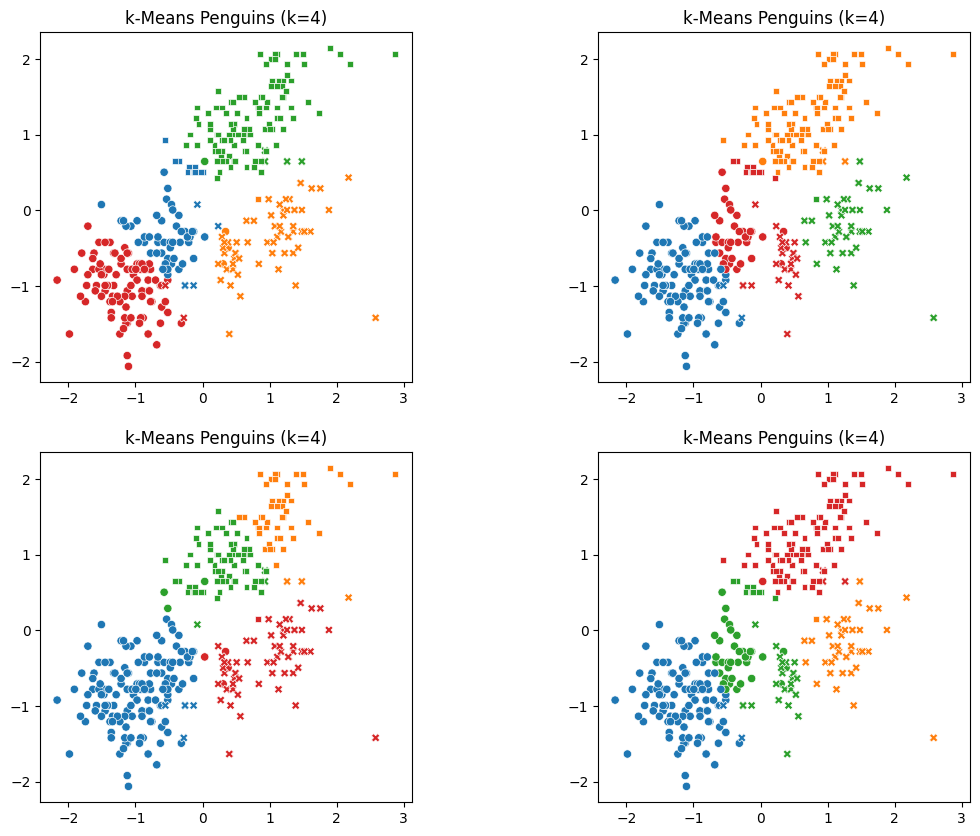

In [9]:
# What if we believe there are 4 clusters in all of the datasets?
#
kmeans_4 = KMeans(n_clusters=4)  # k-Means with 4 clusters, no fixed random state.

# We apply k-Means to each dataset with the `fit_transform()` method.
#
penguins_kmeans_1 = kmeans_4.fit_predict(penguins)
penguins_kmeans_2 = kmeans_4.fit_predict(penguins)
penguins_kmeans_3 = kmeans_4.fit_predict(penguins)
penguins_kmeans_4 = kmeans_4.fit_predict(penguins)

# Now let's see how the proposed clusters look.  We will use the "ideal" labels
# to determine the shapes of the markers in the plots here so that we can compare:
#
plot_all(
    [penguins, penguins, penguins, penguins],
    [
        "k-Means Penguins (k=4)",
        "k-Means Penguins (k=4)",
        "k-Means Penguins (k=4)",
        "k-Means Penguins (k=4)",
    ],
    [penguins_kmeans_1, penguins_kmeans_2, penguins_kmeans_3, penguins_kmeans_4],
    [penguins_labels, penguins_labels, penguins_labels, penguins_labels],
)

💡  Keep in mind when using k-Means: A single run does not give you any
indication confidence that the labeling was stable.  _(A stable labeling is an
indication that the labeling is more likely "correct" with respect to some
real-world relationship.)_

You can run the clustering several times and compare the stability of the
cluster assignments to get an idea of whether the algorithms is seeing "real"
groups or just randomly assigning them based on the initial seed points chosen.

For more information on measuring the stability of a clustering assignment, see
the following article:

<https://amueller.github.io/aml/04-model-evaluation/17-cluster-evaluation.html>

### Mean-Shift Clustering

Mean-Shift clustering provides a powerful technique for clustering a dataset
when we _don't already know the number of clusters_.

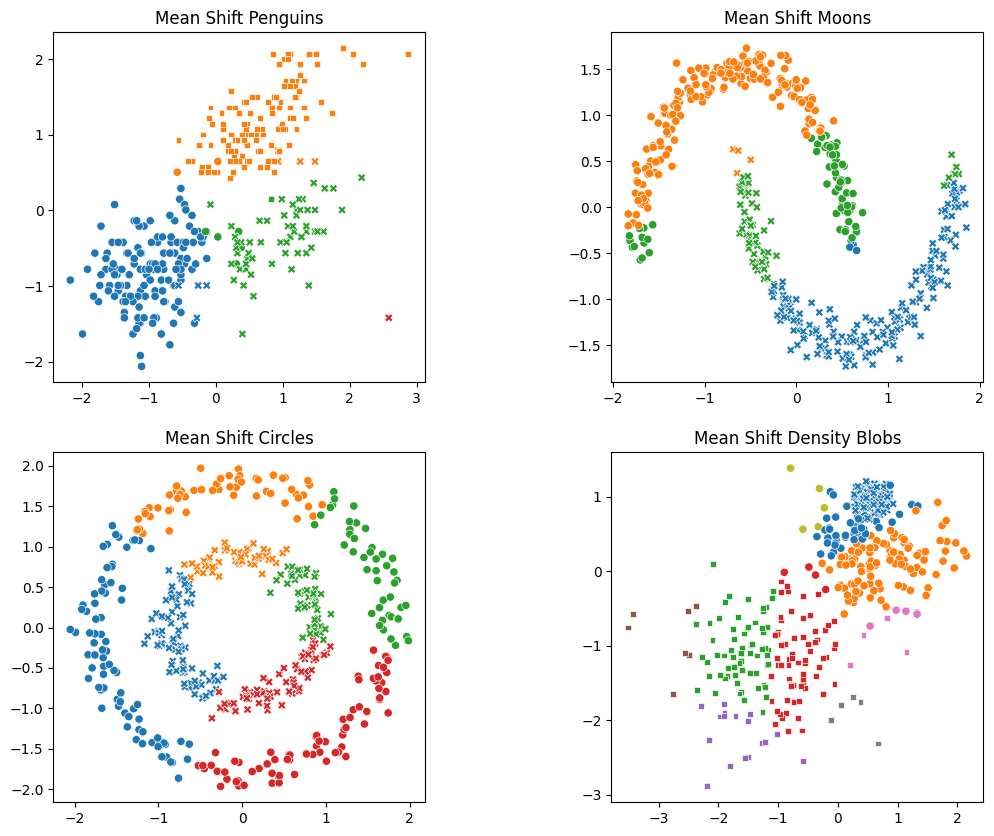

In [10]:
# For each dataset, we need to estimate the bandwidth parameter, then create the
# MeanShift object.  To automate this, we will wrap the two steps up into a function.
def build_MeanShift(X, quantile=0.25):
    bandwidth = cluster.estimate_bandwidth(X, quantile=quantile)
    return MeanShift(bandwidth=bandwidth)


# Now build a MeanShift clusterer for each dataset and use it to fit/predict.
penguins_ms = build_MeanShift(penguins).fit_predict(penguins)
moons_ms = build_MeanShift(moons).fit_predict(moons)
circles_ms = build_MeanShift(circles, quantile=0.2).fit_predict(circles)
density_blobs_ms = build_MeanShift(density_blobs, quantile=0.1).fit_predict(
    density_blobs
)

# Now plot them:
plot_all(
    [penguins, moons, circles, density_blobs],
    [
        "Mean Shift Penguins",
        "Mean Shift Moons",
        "Mean Shift Circles",
        "Mean Shift Density Blobs",
    ],
    [penguins_ms, moons_ms, circles_ms, density_blobs_ms],
    [penguins_labels, moons_labels, circles_labels, density_blobs_labels],
)

🤔  Mean-Shift did a very good job on the Penguins dataset, without needing to know
that there were three groups!  It didn't do so well with the other datasets
though.  Circles and Moons are not "blob-like" enough for this technique to work
well.  In the density blobs dataset, it did (sort of) find the small dense
blob... But at the expense of finding many more small clusters that don't really
exist.

ℹ️  The `bandwidth` parameter is the most important tuning parameter for this
algorithm, and it can be tricky to get just right.   The `estimate_bandwidth()`
function is provided to help find a good bandwidth value, but it also has a
tuning parameter `quantile` that can be a bit finicky.  Some trial-and-error may
be required to get results that seem correct.

### DBSCAN

The DBSCAN technique looks for regions of _similar density_, and assumes that
those regions represent groups of samples.  It is also capable of automatically
identifying _outliers_ (or "noise points") that may not belong to any group.

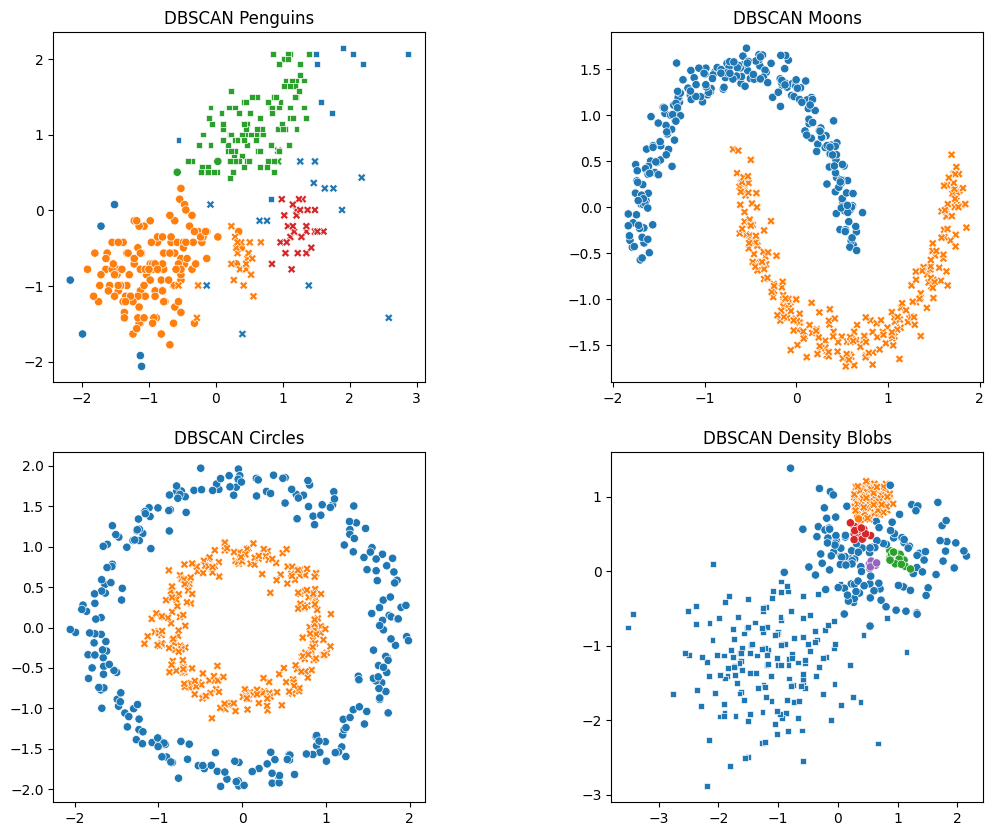

In [11]:
# Like MeanShift, there is an important tuning parameter ('eps') for DBSCAN.
# Use DBSCAN to cluster each dataset:
penguins_DBSCAN = DBSCAN(eps=0.25).fit_predict(penguins)
moons_DBSCAN = DBSCAN(eps=0.3).fit_predict(moons)
circles_DBSCAN = DBSCAN(eps=0.28).fit_predict(circles)
density_blobs_DBSCAN = DBSCAN(eps=0.1).fit_predict(density_blobs)

# Now plot them:
plot_all(
    [penguins, moons, circles, density_blobs],
    [
        "DBSCAN Penguins",
        "DBSCAN Moons",
        "DBSCAN Circles",
        "DBSCAN Density Blobs",
    ],
    [penguins_DBSCAN, moons_DBSCAN, circles_DBSCAN, density_blobs_DBSCAN],
    [penguins_labels, moons_labels, circles_labels, density_blobs_labels],
)

🤔  We can see that DBSCAN did a very good job on the "strange" datasets (moons and
circles).  It also did a decent job with the Penguins dataset.  The performance
on the density blobs data is interesting: It identified the small dense cluster,
but found spurious extra clusters as well.  It also failed to see the two larger
clusters as separate objects.

ℹ️  DBSCAN requires careful tuning of the `eps` parameter, which is related to
the expected density of clusters.  When there is a wide variation in the density
of "real" clusters, DBSCAN can fail to perform well (as it did here).  However,
if there is a sparse background of noisy points with some clusters of similar
density, DBSCAN will find those clusters even if they are not "blob-shaped".

### HDBSCAN

The HDBSCAN technique performs DBSCAN over varying epsilon (`eps`) values and integrates the result to find a clustering that gives the best stability over epsilon. This allows HDBSCAN to find clusters of varying densities (unlike DBSCAN), and be more robust to parameter selection.

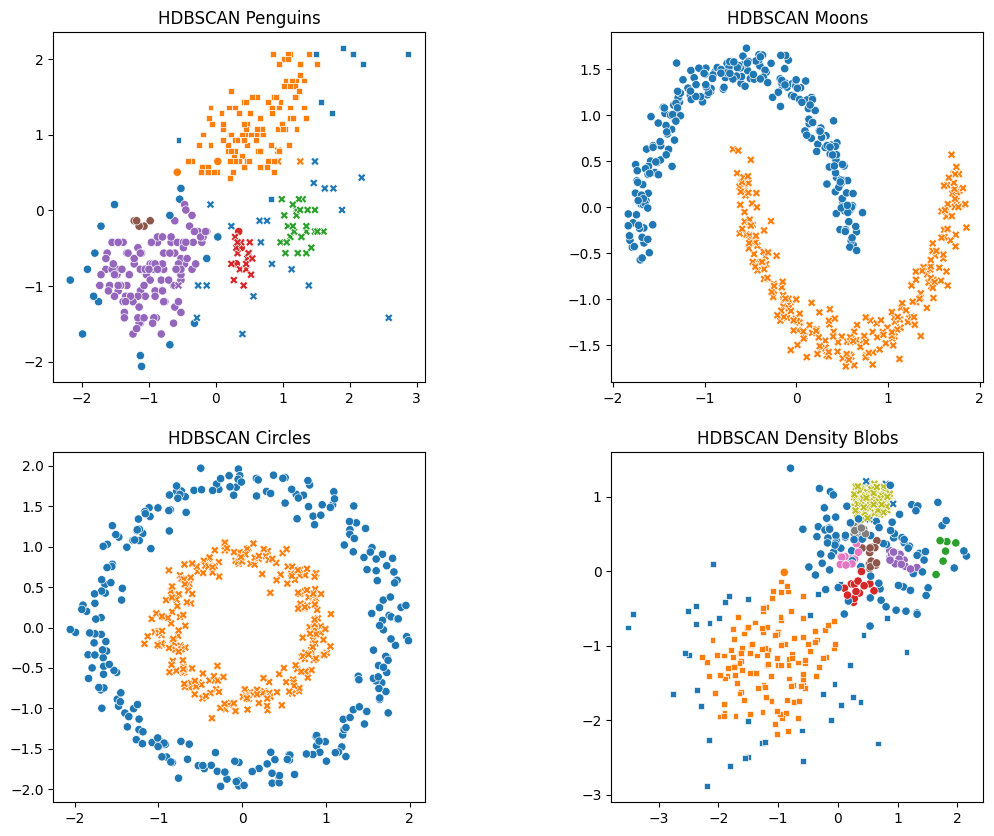

In [12]:
# HDBSCAN isn't as sensitive to tuning parameters as DBSCAN, although tuning the 
# `min_cluster_size` can be helpful if you have an idea of how many values should
# be contained in even the smallest cluster.
# Use HDBSCAN to cluster each dataset:
penguins_HDBSCAN = HDBSCAN().fit_predict(penguins)
moons_HDBSCAN = HDBSCAN().fit_predict(moons)
circles_HDBSCAN = HDBSCAN().fit_predict(circles)
density_blobs_HDBSCAN = HDBSCAN().fit_predict(density_blobs)

# Now plot them:
plot_all(
    [penguins, moons, circles, density_blobs],
    [
        "HDBSCAN Penguins",
        "HDBSCAN Moons",
        "HDBSCAN Circles",
        "HDBSCAN Density Blobs",
    ],
    [penguins_HDBSCAN, moons_HDBSCAN, circles_HDBSCAN, density_blobs_HDBSCAN],
    [penguins_labels, moons_labels, circles_labels, density_blobs_labels],
)

🤔  HDBSCAN with defaults for all parameters did a pretty good job.  It was really good at the circles and moons, but introduced some spurious extra clusters in penguins and density blobs.

### Agglomerative Hierarchical Clustering

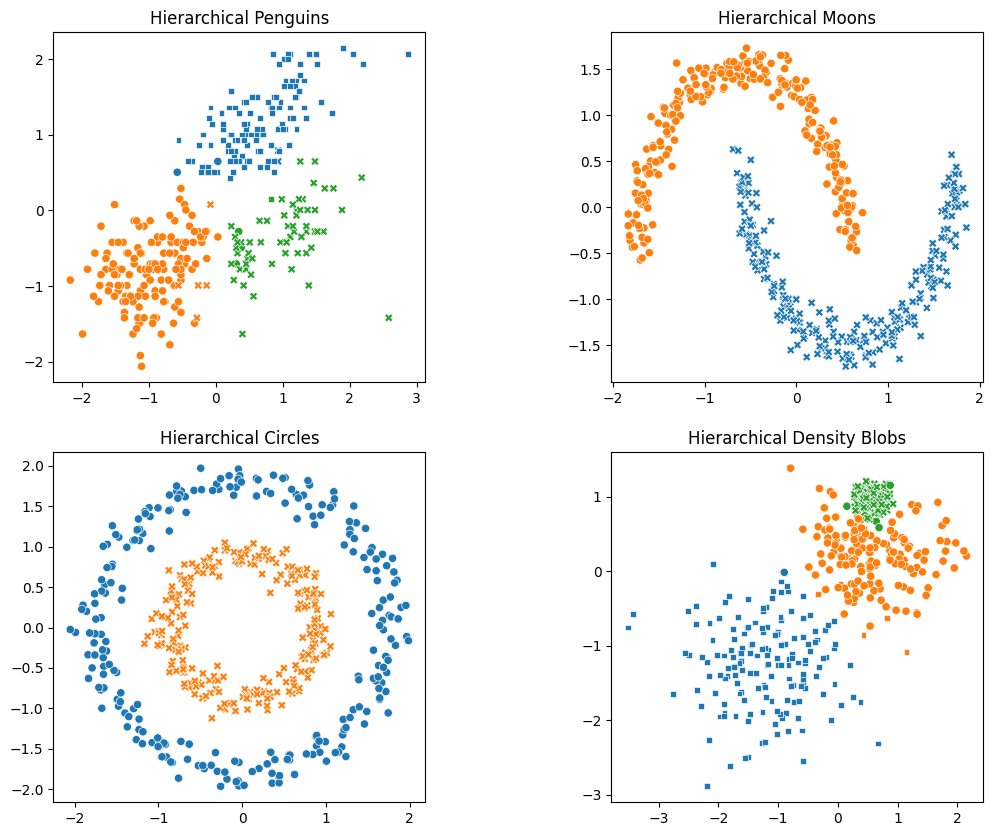

In [13]:
# Use agglomerative clustering to cluster each dataset:
penguins_ag = AgglomerativeClustering(n_clusters=3, linkage="ward").fit_predict(
    penguins
)
moons_ag = AgglomerativeClustering(n_clusters=2, linkage="single").fit_predict(moons)
circles_ag = AgglomerativeClustering(n_clusters=2, linkage="single").fit_predict(
    circles
)
density_blobs_ag = AgglomerativeClustering(n_clusters=3, linkage="ward").fit_predict(
    density_blobs
)

# Now plot them:
plot_all(
    [penguins, moons, circles, density_blobs],
    [
        "Hierarchical Penguins",
        "Hierarchical Moons",
        "Hierarchical Circles",
        "Hierarchical Density Blobs",
    ],
    [penguins_ag, moons_ag, circles_ag, density_blobs_ag],
    [penguins_labels, moons_labels, circles_labels, density_blobs_labels],
)

🤔  The hierarchical clustering technique did a pretty good job on all the datasets,
but we had to do some tuning.  Specifically, the choice of `linkage` can make a
big difference, as can the choice of `metric` (which we did not tune here).  We
also provided the model with our desired number of clusters.  Agglomerative
Clustering will work _without_ the number of clusters provided, but it might not
produce the desired result.  If you know the expected number of clusters, it is
very helpful to provide it.

ℹ️  **Another** thing you can do with hierarchical clustering is to visualize the
relationships between the samples as a **_dendrogram_**.  A dendrogram is a
tree-like representation that shows every possible clustering from a single
group to $N$ groups (where $N$ is the total number of samples).  The height of
the vertical lines represent changes in similarity between splits.

You can use this visualization to get an idea of how many clusters _should_
exist in the dataset.  **This can be used to determine $k$ before performing
k-Means clustering, or for other models that require knowing the number of
groups beforehand.**

💁  The dendrogram visualization is available from SciPy. (See:
<https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram>)

To see it in action, we will generate dendrogram for the "penguins"
dataset:

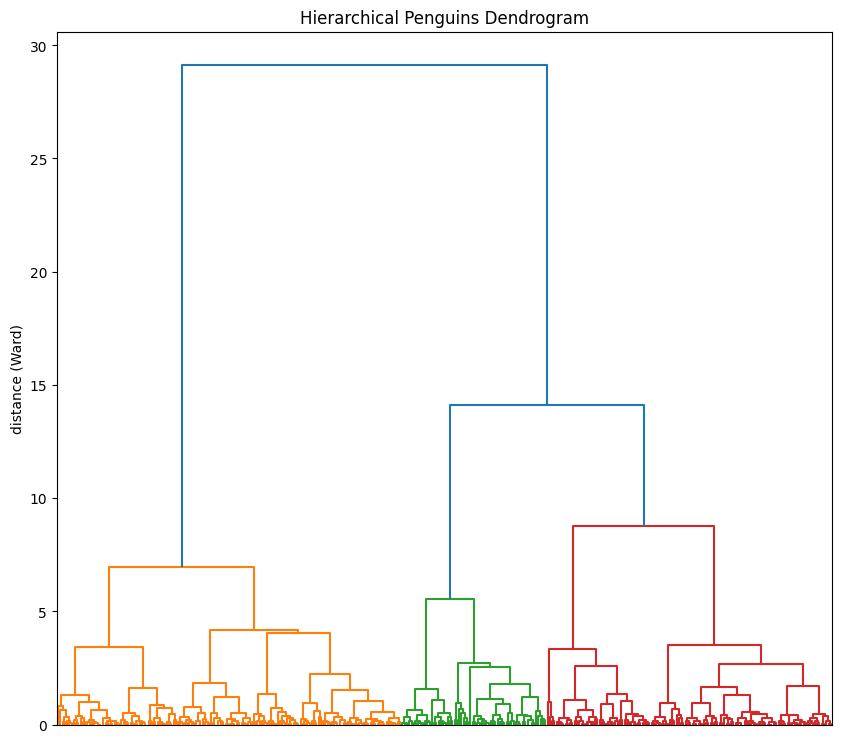

In [14]:
linkage_matrix = linkage(penguins, "ward")
plt.figure(figsize=(10, 9))
plt.title("Hierarchical Penguins Dendrogram")
plt.ylabel("distance (Ward)")
dendrogram(linkage_matrix, no_labels=True, color_threshold=10)
plt.show()

By examining the vertical lines, you can determine the "best" number of clusters
by choosing where to "cut" the graph with an imaginary horizontal line.

### Gaussian Mixture Model

The Gaussian Mixture Model (GMM) works by assuming that clusters are
multi-dimensional Gaussian distributions (which look like roughly "circular"
blobs that are denser in the middle).  It is quite flexible if you have
"blob-like" clusters, and GMM-like clusters occur frequently in natural
datasets.

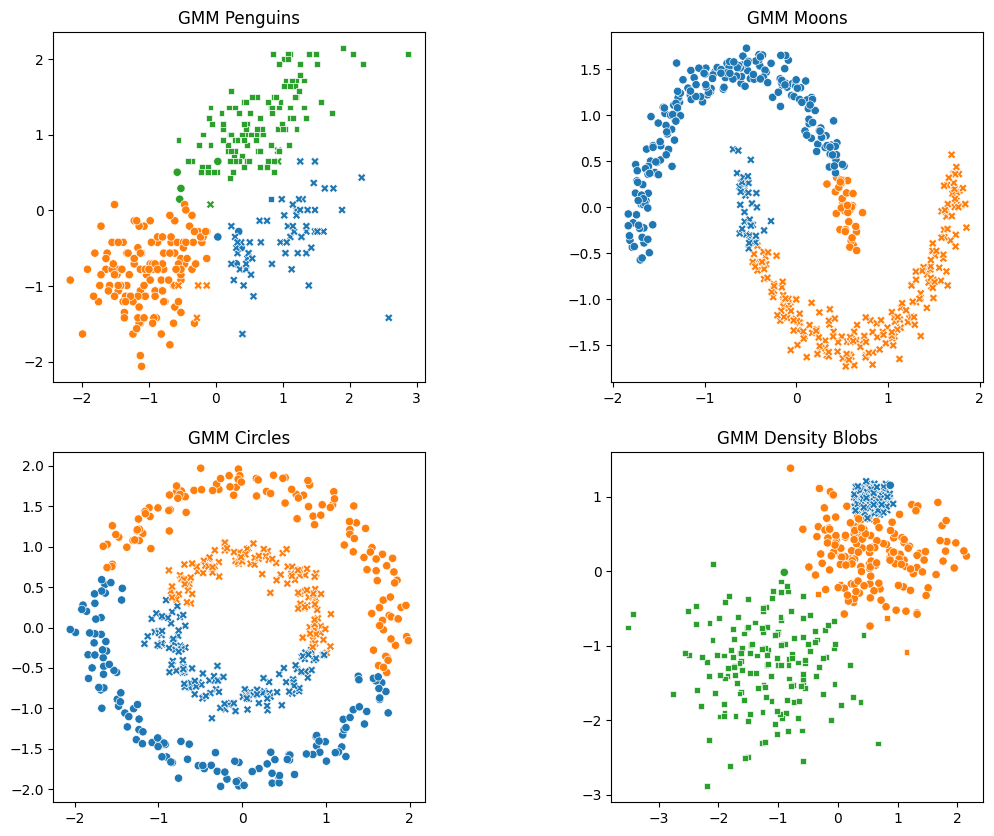

In [15]:
from sklearn.mixture import GaussianMixture

# Use a GMM to cluster each dataset.  We assume that penguins and
# density blobs have three clusters, and that moons and circles have two.
#
penguins_ag = GaussianMixture(n_components=3).fit_predict(penguins)
moons_ag = GaussianMixture(n_components=2).fit_predict(moons)
circles_ag = GaussianMixture(n_components=2).fit_predict(circles)
density_blobs_ag = GaussianMixture(n_components=3).fit_predict(density_blobs)

# Now plot them:
plot_all(
    [penguins, moons, circles, density_blobs],
    [
        "GMM Penguins",
        "GMM Moons",
        "GMM Circles",
        "GMM Density Blobs",
    ],
    [penguins_ag, moons_ag, circles_ag, density_blobs_ag],
    [penguins_labels, moons_labels, circles_labels, density_blobs_labels],
)

🤔  The GMM did a very good job on the "blob-like" datasets "penguins" and "density
blobs".  In fact, it probably did _best_ on density blobs (versus the other
methods we tried).

However, it does not do as well with the datasets whose values aren't
"blob-like" in shape.


## Thank You!

This notebook in tutorial and completed form is available at:

<https://jcausey-astate.github.io/ASRI-2025/>
